<a href="https://colab.research.google.com/github/maingga/PCVK_RPL_2024/blob/main/week5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
from google.colab.patches import cv2_imshow
import math
import os
import glob
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

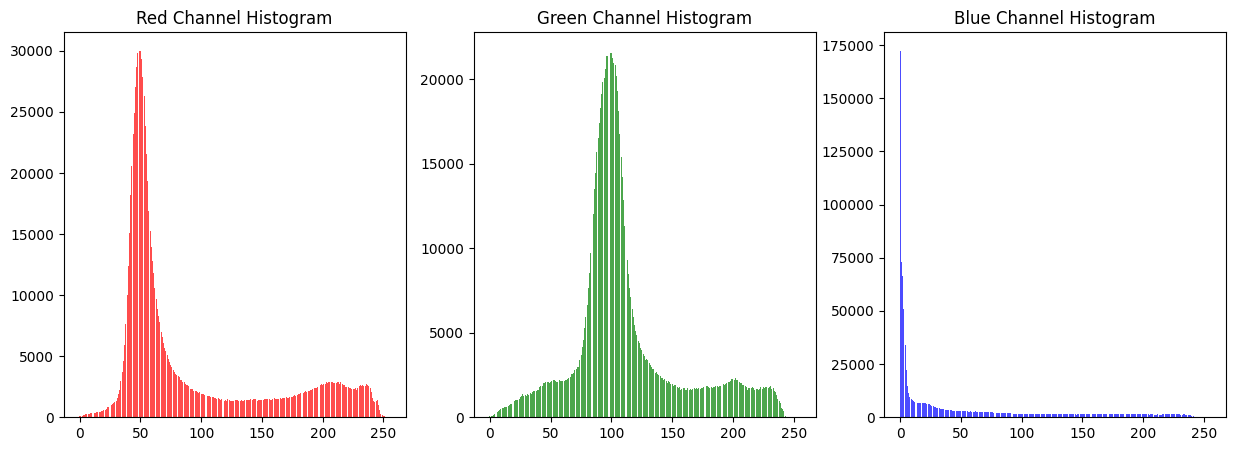

In [2]:
img = cv2.imread('kitten01.jpg')

def create_histogram_manual(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    hist_r = np.zeros(256)
    hist_g = np.zeros(256)
    hist_b = np.zeros(256)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            hist_r[image_rgb[i, j, 0]] += 1
            hist_g[image_rgb[i, j, 1]] += 1
            hist_b[image_rgb[i, j, 2]] += 1

    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.bar(range(256), hist_r, color='red', alpha=0.7)
    plt.title('Red Channel Histogram')
    plt.subplot(132)
    plt.bar(range(256), hist_g, color='green', alpha=0.7)
    plt.title('Green Channel Histogram')
    plt.subplot(133)
    plt.bar(range(256), hist_b, color='blue', alpha=0.7)
    plt.title('Blue Channel Histogram')
    plt.show()

create_histogram_manual(img)

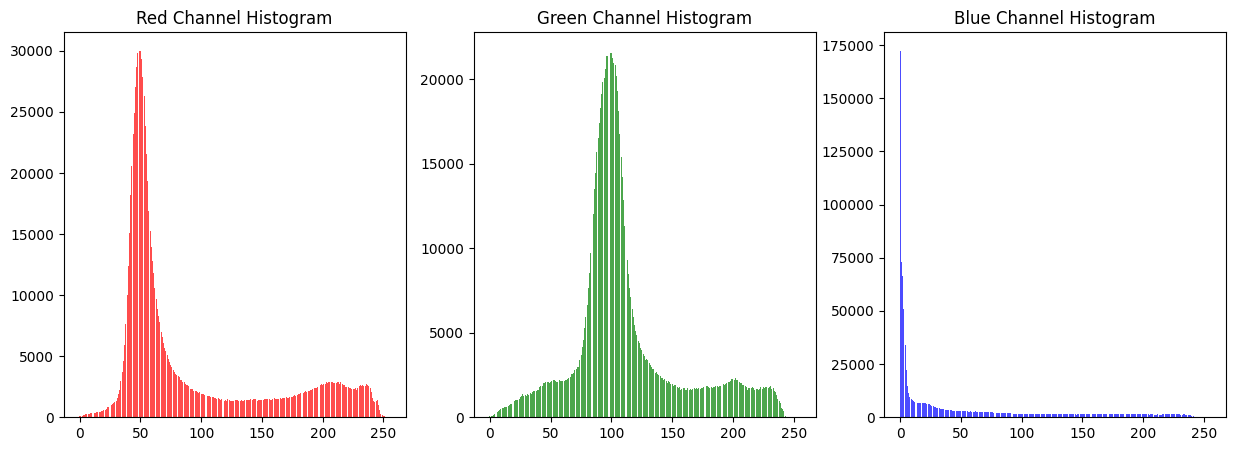

In [3]:
def create_histogram_numpy(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 5))
    for i, color in enumerate(['red', 'green', 'blue']):
        plt.subplot(1, 3, i+1)
        hist, bins = np.histogram(image_rgb[:,:,i].ravel(), 256, [0, 256])
        plt.bar(range(256), hist, color=color, alpha=0.7)
        plt.title(f'{color.capitalize()} Channel Histogram')
    plt.show()

create_histogram_numpy(img)

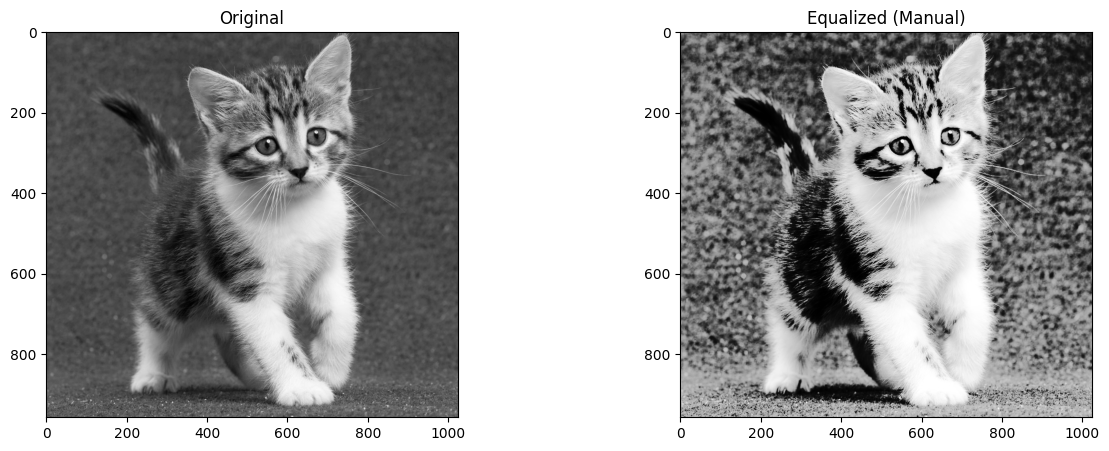

In [4]:
img2 = cv2.imread('kitten01.jpg')

def histogram_equalization_manual(image):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    hist = np.zeros(256)
    for i in range(gray.shape[0]):
        for j in range(gray.shape[1]):
            hist[gray[i, j]] += 1

    cum_hist = np.cumsum(hist)

    cum_hist_normalized = cum_hist * 255 / cum_hist[-1]

    # Create lookup table
    lookup_table = np.round(cum_hist_normalized).astype('uint8')

    equalized = np.zeros_like(gray)
    for i in range(gray.shape[0]):
        for j in range(gray.shape[1]):
            equalized[i, j] = lookup_table[gray[i, j]]

    return equalized, gray

eq_manual, gray_manual = histogram_equalization_manual(img2)
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(gray_manual, cmap='gray')
plt.title('Original')
plt.subplot(122)
plt.imshow(eq_manual, cmap='gray')
plt.title('Equalized (Manual)')
plt.show()

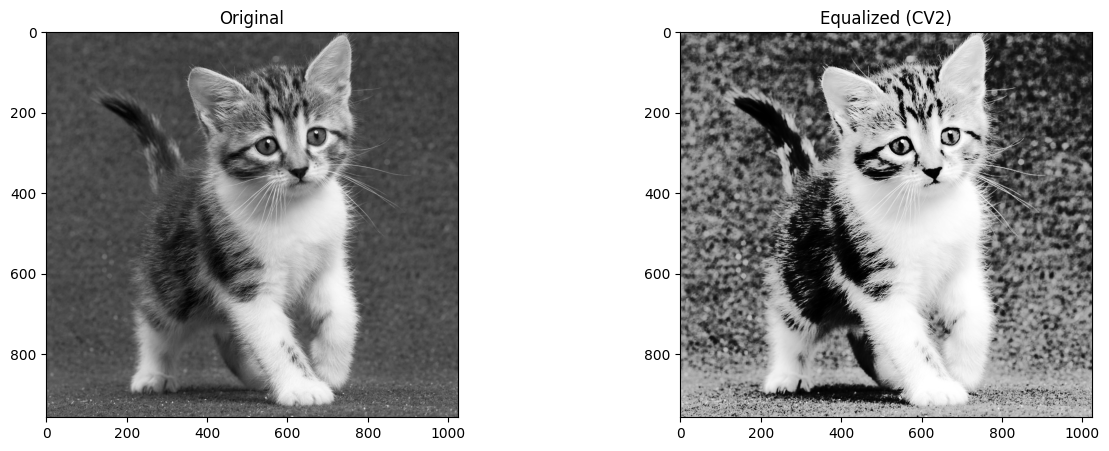

In [5]:
def histogram_equalization_cv2(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(gray)
    return equalized, gray

eq_cv2, gray_cv2 = histogram_equalization_cv2(img2)
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(gray_cv2, cmap='gray')
plt.title('Original')
plt.subplot(122)
plt.imshow(eq_cv2, cmap='gray')
plt.title('Equalized (CV2)')
plt.show()

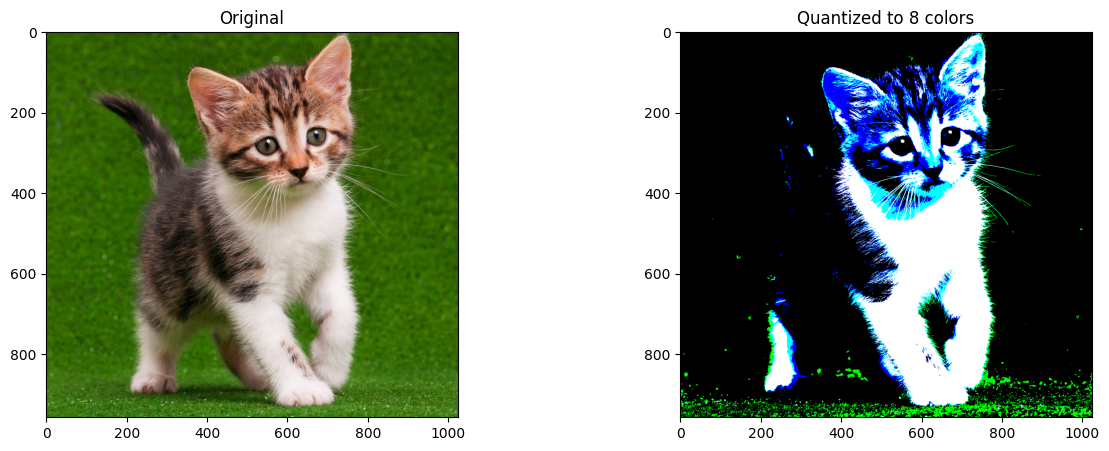

In [6]:
def quantize_to_8_colors(image):
    # Define the 8 colors
    colors = np.array([[0, 0, 0],     # Black
                       [0, 255, 0],   # Green
                       [255, 255, 0], # Yellow
                       [0, 0, 255],   # Blue
                       [0, 255, 255], # Cyan
                       [255, 0, 255], # Magenta
                       [255, 0, 0],   # Red
                       [255, 255, 255]]) # White

    pixels = image.reshape(-1, 3)
    quantized = np.zeros_like(pixels)

    for i, pixel in enumerate(pixels):
        distances = np.sqrt(np.sum((colors - pixel) ** 2, axis=1))
        closest_color = colors[np.argmin(distances)]
        quantized[i] = closest_color

    return quantized.reshape(image.shape)

quantized = quantize_to_8_colors(img2)
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.subplot(122)
plt.imshow(quantized)
plt.title('Quantized to 8 colors')
plt.show()

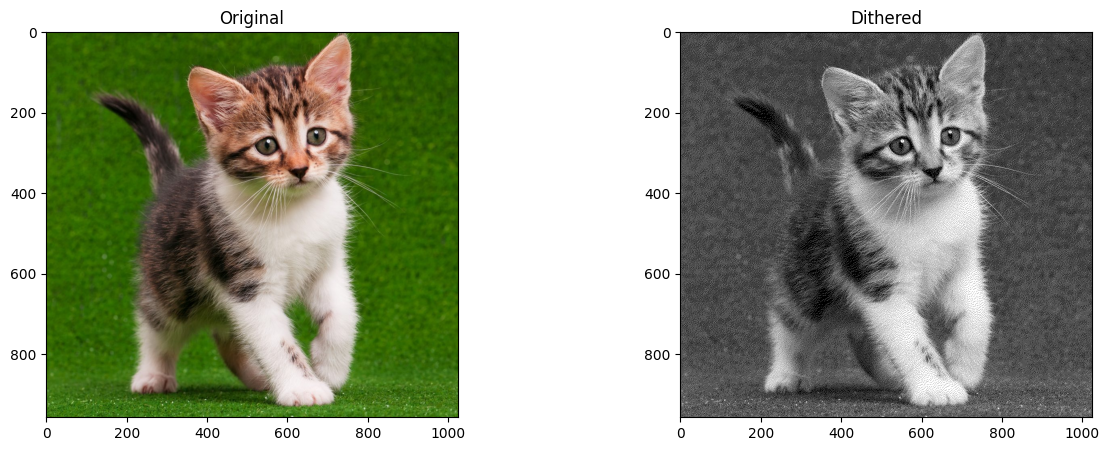

In [8]:
def floyd_steinberg_dithering(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    height, width = image.shape
    dithered = np.copy(image).astype(float)

    for y in range(height-1):
        for x in range(1, width-1):
            old_pixel = dithered[y, x]
            new_pixel = np.round(old_pixel / 255.0) * 255
            dithered[y, x] = new_pixel
            error = old_pixel - new_pixel

            dithered[y, x+1] += error * 7/16
            dithered[y+1, x-1] += error * 3/16
            dithered[y+1, x] += error * 5/16
            dithered[y+1, x+1] += error * 1/16

    return dithered.astype(np.uint8)

dithered = floyd_steinberg_dithering(img2)
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.subplot(122)
plt.imshow(dithered, cmap='gray')
plt.title('Dithered')
plt.show()

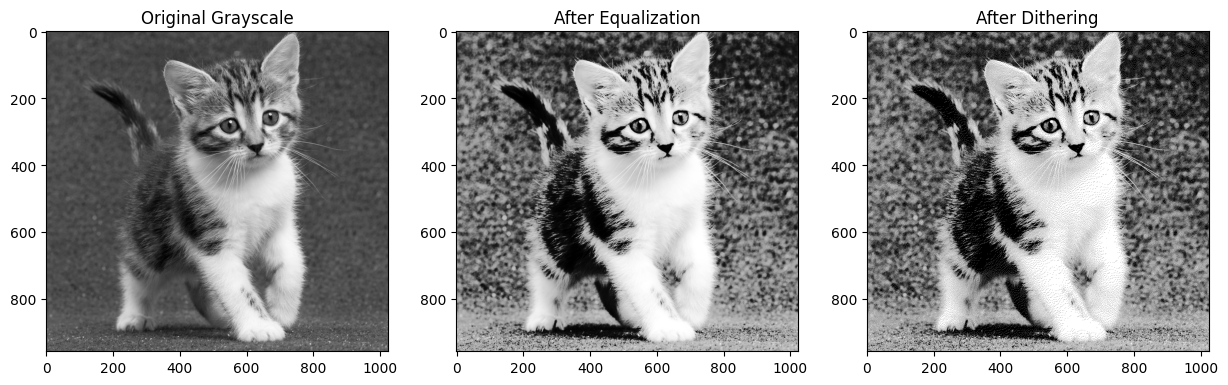

In [10]:
gray_lc = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
equalized_lc = cv2.equalizeHist(gray_lc)
dithered_lc = floyd_steinberg_dithering(equalized_lc)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(gray_lc, cmap='gray')
plt.title('Original Grayscale')
plt.subplot(132)
plt.imshow(equalized_lc, cmap='gray')
plt.title('After Equalization')
plt.subplot(133)
plt.imshow(dithered_lc, cmap='gray')
plt.title('After Dithering')
plt.show()